In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

"import os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

<h4> Importing Libraries </h4>

In [3]:
import os
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from keras.optimizers import Adam

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

import os, cv2, json
from PIL import Image

<h4> Working Directory </h4>

In [4]:
WORK_DIR = '/kaggle/input/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

<h4> First look at the data</h4>

In [5]:
print('Train images: %d' %len(os.listdir(os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [6]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [7]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


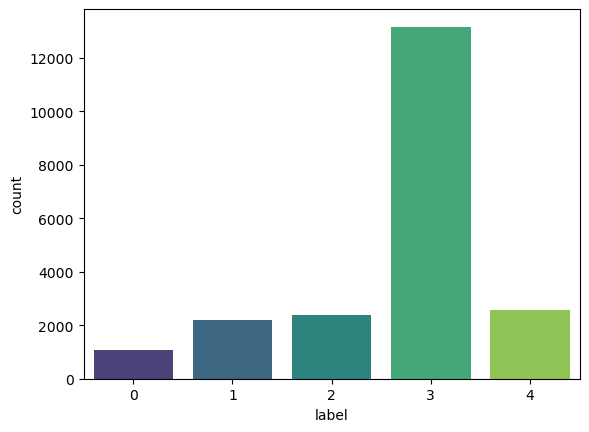

In [8]:
sns.countplot(x=train_labels["label"],palette = sns.color_palette("viridis", 5))
plt.show()


In [9]:
BATCH_SIZE = 8
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 20
TARGET_SIZE = 512


In [10]:
STEPS_PER_EPOCH

2139.7000000000003

In [11]:
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     rotation_range = 45,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (50, 50),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (50, 50),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [12]:
train_labels.label = train_labels.label.astype('str')

In [13]:
file_directories = 6
print('Train images: %d' %len(os.listdir(os.path.join(WORK_DIR, "train_images"))*file_directories))

Train images: 128382


In [14]:
def create_model():
    model = models.Sequential()

    model.add(EfficientNetB0(include_top = False, weights = 'imagenet',
                             input_shape = (50, 50, 3)))
    
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(5, activation = "softmax"))

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [15]:
model = create_model()
model.summary()


16705208/16705208 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________


In [16]:
model_save = ModelCheckpoint('./best_baseline_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit_generator(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/20


2023-03-13 02:38:43.519263: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2140/2139 [==============================] - ETA: 0s - loss: 1.0997 - acc: 0.6172
Epoch 1: val_loss improved from inf to 1.04244, saving model to ./best_baseline_model.h5
2139/2139 [==============================] - 369s 166ms/step - loss: 1.0997 - acc: 0.6172 - val_loss: 1.0424 - val_acc: 0.6572 - lr: 0.0010
Epoch 2/20
2140/2139 [==============================] - ETA: 0s - loss: 0.9618 - acc: 0.6524
Epoch 2: val_loss improved from 1.04244 to 0.88734, saving model to ./best_baseline_model.h5
2139/2139 [==============================] - 230s 107ms/step - loss: 0.9618 - acc: 0.6524 - val_loss: 0.8873 - val_acc: 0.6784 - lr: 0.0010
Epoch 3/20
2140/2139 [==============================] - ETA: 0s - loss: 0.9196 - acc: 0.6628
Epoch 3: val_loss did not improve from 0.88734
2139/2139 [==============================] - 230s 108ms/step - loss: 0.9196 - acc: 0.6628 - val_loss: 0.8928 - val_acc: 0.6782 - lr: 0.0010
Epoch 4/20
2140/2139 [==============================] - ETA: 0s - loss: 0.8968 - ac

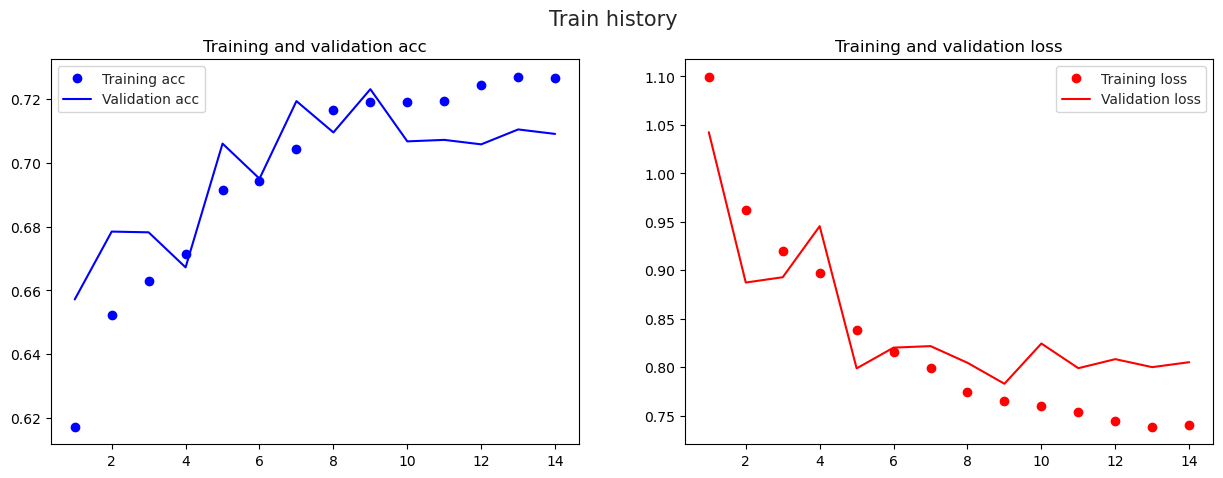

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

## Predictions

In [19]:
ss = pd.read_csv(os.path.join(WORK_DIR, "sample_submission.csv"))
ss


,image_id,label
0,2216849948.jpg,4


In [23]:
preds = []

for image_id in ss.image_id:
    image = Image.open(os.path.join(WORK_DIR,  "test_images", image_id))
    image = image.resize((50, 50))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image))+1)

ss['label'] = preds
ss


1/1 [==============================] - 0s 29ms/step


,image_id,label
0,2216849948.jpg,4
